In [1]:
# General imports
import time
import numpy as np
from itertools import permutations
import networkx as nx

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# The IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Session

# Qiskit Optimization Module Tools
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Tsp
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

# Optimization tools
from scipy.optimize import minimize
from qiskit.algorithms.minimum_eigensolvers import MinimumEigensolver, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import L_BFGS_B, SLSQP, SPSA


# Plotting functions
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%config InlineBackend.figure_format='retina'


### Define some tools for drawing and plotting graph problems

In [2]:
# Draw and visualize graph solution
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=900, alpha=0.9, ax=default_axes, pos=pos, node_shape="o")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


def PlotGraph(ideal, mean):
    plt.figure(figsize=(8, 6))
    # Plot label
    for value in range(len(mean)):
        plt.plot(mean[value], label="Proposal {}".format(value+1) )
        
    # Ideal plot
    plt.axhline(y=ideal, color="tab:red", ls="--", label="Target")
    plt.legend(loc="best")
    plt.xlabel("Optimizer iteration")
    plt.ylabel("Energy")
    
    # Plot graph title
    plt.title("TSP Entangler Line {} Constraint".format(len(mean)))
    plt.show()

#### Here we define a "random" instance of the traveling salesman problem

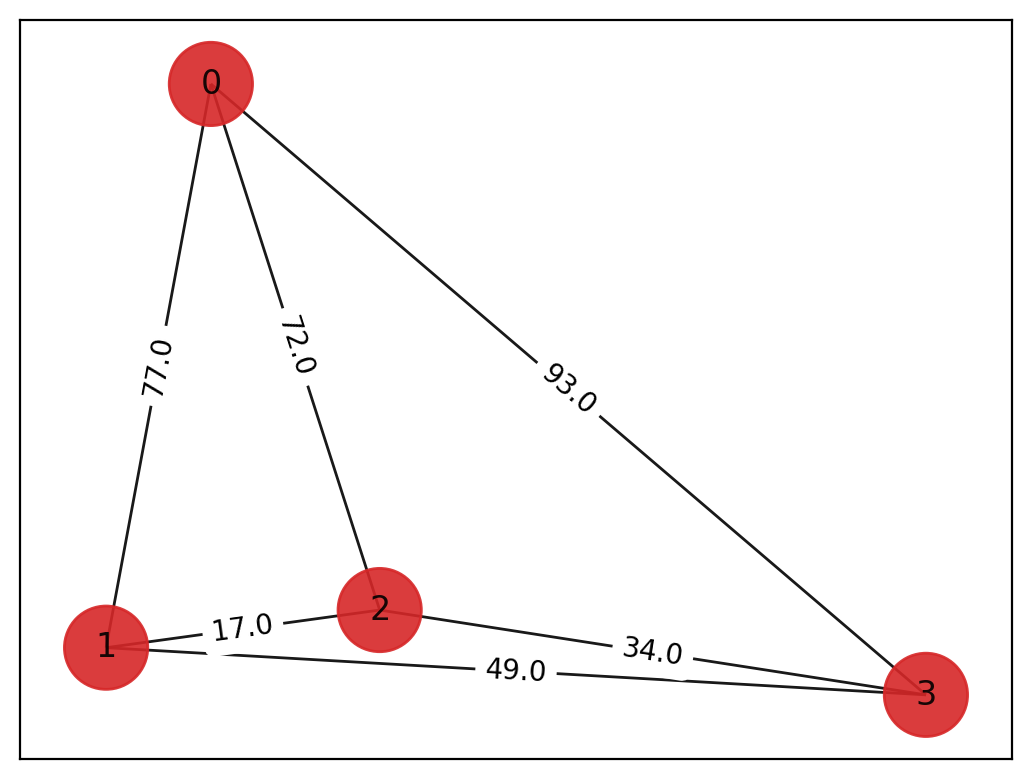

In [3]:
n = 4
num_qubits = n**2

# the target graph
tsp = Tsp.create_random_instance(n, seed=12)

colors = ["tab:red" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]

draw_graph(tsp.graph, colors, pos)

### Now converting our optimization problem to the language of a physical model, the Ising model.

In [4]:
qp = tsp.to_quadratic_program()
qp2qubo = QuadraticProgramToQubo()

qubo = qp2qubo.convert(qp)
observable, offset = qubo.to_ising()

In [5]:
observable

PauliSumOp(SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIZZIII', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIZZIIII', 'IIIIIIIIIZIIIIZI', 'IIIIIIIIIZIIIZII', 'IIIIIIIIIZIIZIII', 'IIIIIIIIIZIZIIII', 'IIIIIIIIIZZIIIII', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIIZIIIIZII', 'IIIIIIIIZIIIZIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIZIZIIIII', 'IIIIIIIIZZIIIIII', 'IIIIIIIZIIIIIIIZ', 'IIIIIIIZIIIIIIZI', 'IIIIIIIZIIIIZIII', 'IIIIIIIZIIIZIIII', 'IIIIIIIZIIZIIIII', 'IIIIIIIZZIIIIIII', 'IIIIIIZIIIIIIIIZ', 'IIIIIIZIIIIIIIZI', 'IIIIIIZIIIIII

### Creating a parameterized quantum circuit

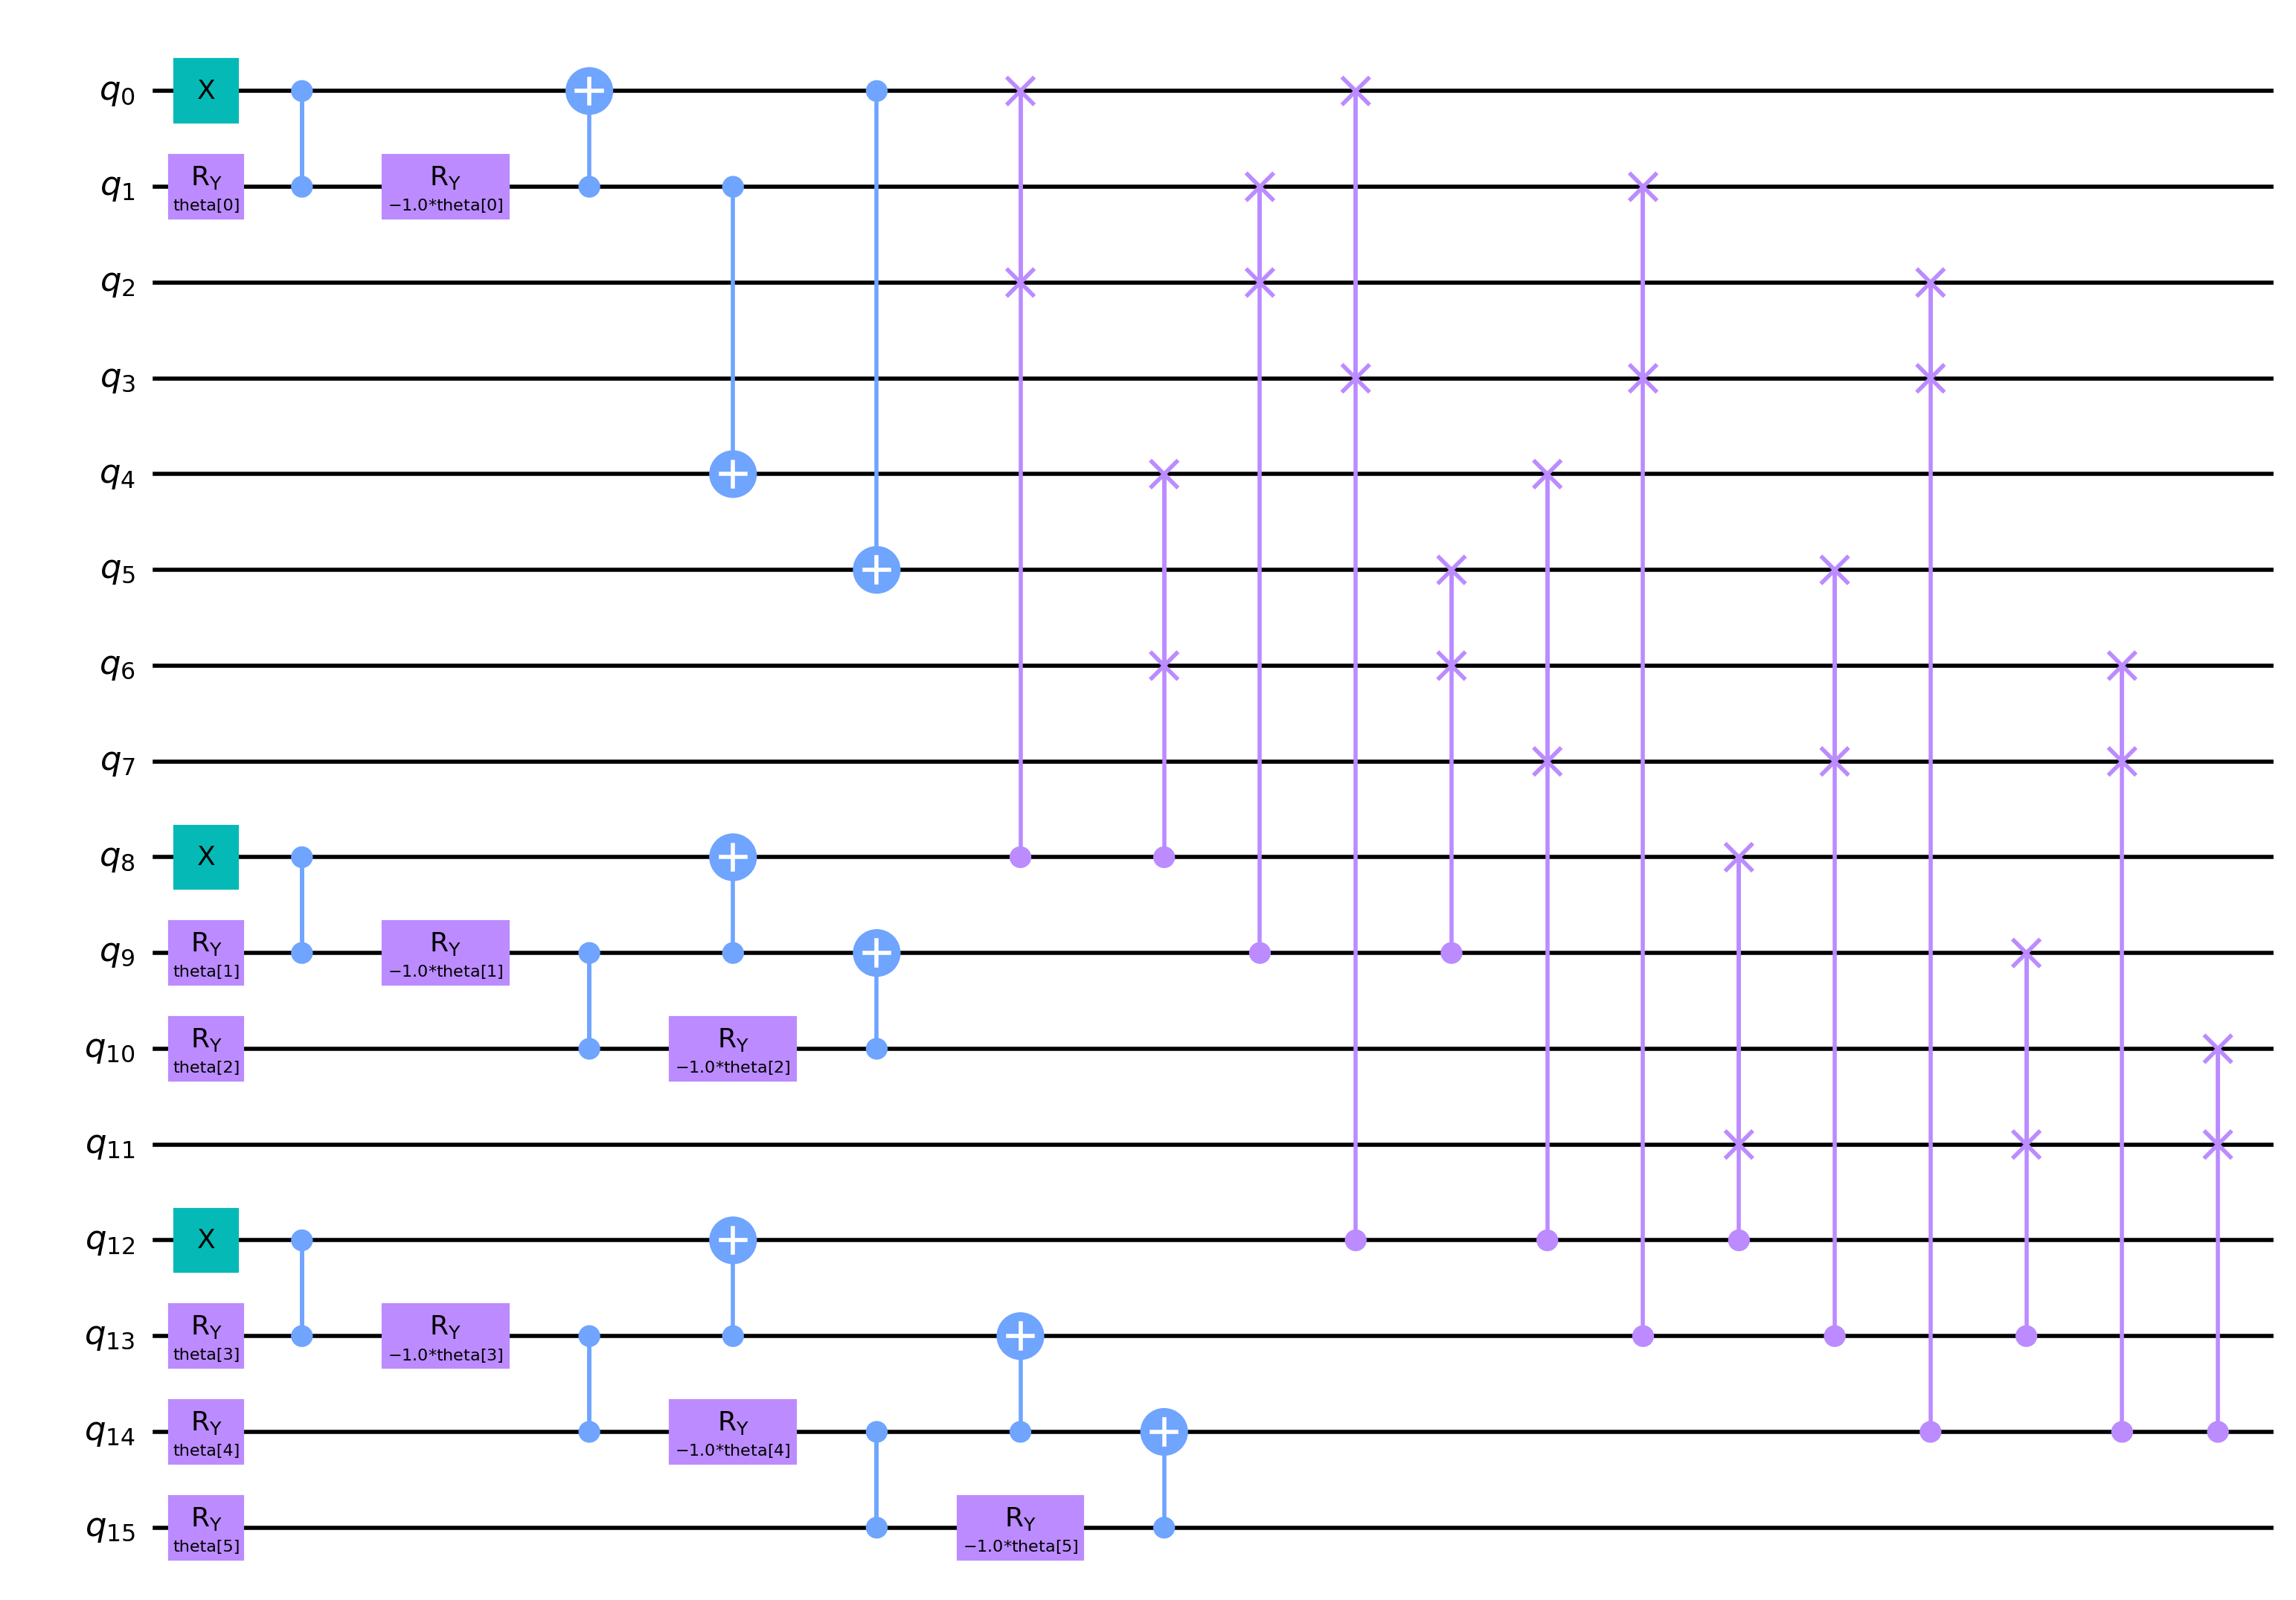

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

model = QuantumCircuit(n**2)
num_params = (n-1)*n//2
theta = ParameterVector('theta',length = num_params)

model.x(0)

model.ry(theta[0],1)
model.cz(0,1)
model.ry(-theta[0],1)
model.cx(1,0)

model.cx(1,4)
model.cx(0,5)

model.x(8)

model.ry(theta[1],9)
model.cz(8,9)
model.ry(-theta[1],9)

model.ry(theta[2],10)
model.cz(9,10)
model.ry(-theta[2],10)

model.cx(9,8)
model.cx(10,9)

model.cswap(8, 0, 2)
model.cswap(8, 4, 6)
model.cswap(9, 1, 2)
model.cswap(9, 5, 6)

model.x(12)

model.ry(theta[3],13)
model.cz(12,13)
model.ry(-theta[3],13)

model.ry(theta[4],14)
model.cz(13,14)
model.ry(-theta[4],14)

model.ry(theta[5],15)
model.cz(14,15)
model.ry(-theta[5],15)

model.cx(13,12)
model.cx(14,13)
model.cx(15,14)
model.cswap(12, 0, 3)
model.cswap(12, 4, 7)
model.cswap(12, 8, 11)

model.cswap(13, 1, 3)
model.cswap(13, 5, 7)
model.cswap(13, 9, 11)

model.cswap(14, 2, 3)
model.cswap(14, 6, 7)
model.cswap(14, 10, 11)

model.draw("mpl")

### Creating a callback tool so that we can get some info about how it's going

In [7]:
def build_callback(ansatz, observable, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        callback_dict["cost_history"].append(
            estimator.run(ansatz, observable, parameter_values=current_vector).result().values[0]
        )
        # Grab the current time
        current_time = time.perf_counter()
        # Find the total time of the execute (after the 1st iteration)
        if callback_dict["iters"] > 1:
            callback_dict["_total_time"] += current_time - callback_dict["_prev_time"]
        # Set the previous time to the current time
        callback_dict["_prev_time"] = current_time
        # Compute the average time per iteration and round it
        time_str = (
            round(callback_dict["_total_time"] / (callback_dict["iters"] - 1), 2)
            if callback_dict["_total_time"]
            else "-"
        )
        # Print to screen on single line
        print(
            "Iters. done: {} [Avg. time per iter: {}]".format(callback_dict["iters"], time_str),
            end="\r",
            flush=True,
        )

    return callback

In [8]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "_total_time": 0,
    "_prev_time": None,
}

### Here we define a cost function, the thing we use to measure the performance of our solution

In [9]:
## VQE cost function and minimization

# Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function. By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian. With the Runtime `Estimator` directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple:

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    Cost_Function = estimator.run(ansatz, observable, parameter_values = params).result().values[0]
    return Cost_Function

### We are now ready to start the optimization algorithm

In [ ]:
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import QiskitRuntimeService

# # Initialize your session
# session = Session(backend = backend)
service = QiskitRuntimeService(channel = 'ibm_quantum')
backend = service.get_backend("ibmq_qasm_simulator")

# estimator = Estimator(session = session, options = {"shots": int(1e4)})
x0 = 2 * np.pi * np.random.random(num_params)
with Session(backend = backend) as session:
    estimator = Estimator(options = {"shots": int(1e4)})
    callback = build_callback(model, observable, estimator, callback_dict)
    res = minimize(
        cost_func,
        x0,
        # x0[0:8],
        args = (model, observable, estimator),
        method = "cobyla",
        options = {"maxiter": 100},
        tol = 1e-2, 
        callback = callback,
    )

In [ ]:
res

### And we can now plot our results

In [ ]:
all(callback_dict["prev_vector"] == res.x)
callback_dict["iters"] == res.nfev
# We can also now view the progress towards convergence as monitored by the cost history at each iteration:

fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

In [ ]:
# Plot convergence
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(observable)
energy_numpy = result.eigenvalue.real

print(energy_numpy, res.get("fun"))

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.axhline(energy_numpy, linestyle = '--', color = 'r')

In [ ]:
log_list = []
for i in range(len(callback_dict["cost_history"])):
    log_list.append(np.log10(callback_dict["cost_history"][i]-energy_numpy))

all(callback_dict["prev_vector"] == res.x)
callback_dict["iters"] == res.nfev
# We can also now view the progress towards convergence as monitored by the cost history at each iteration:

fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), log_list)
ax.set_xlabel("Iterations")
ax.set_ylabel("Log Error")